In [59]:
from headers import *
# %matplotlib notebook

Defining a Class for DMPs

In [64]:
class DMP():
	
	def __init__(self,timesteps=100):

		self.alphaz = 25.0
		self.betaz = self.alphaz/4
		self.alpha = 1*self.alphaz/3    
        
		self.time_steps = timesteps
		self.tau = self.time_steps

		self.dimensions = 3
		self.number_kernels = max(self.time_steps,500)
		self.gaussian_kernels = npy.zeros((self.number_kernels,2))

		self.weights = npy.zeros((self.number_kernels, self.dimensions))

		self.demo_pos = npy.zeros((self.time_steps, self.dimensions))
		self.demo_vel = npy.zeros((self.time_steps, self.dimensions))
		self.demo_acc = npy.zeros((self.time_steps, self.dimensions))

		self.target_forces = npy.zeros((self.time_steps, self.dimensions))        
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))
		self.vector_phase = npy.zeros(self.time_steps)
        
# Defining Rollout variables.
		self.rollout_time = max(self.time_steps,200)
		self.rollout_time = self.time_steps    
		self.dt = 1./self.rollout_time
		self.pos_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.acc_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.force_roll = npy.zeros((self.rollout_time,self.dimensions))                
		self.goal = npy.zeros(self.dimensions)
		self.start = npy.zeros(self.dimensions)  
		self.initial_velocity = npy.zeros(self.dimensions)

	def load_trajectory(self,pos,vel,acc):
		self.demo_pos = copy.deepcopy(pos)
		self.demo_vel = copy.deepcopy(vel)
		self.demo_acc = copy.deepcopy(acc)

	def initialize_variables(self):	
		self.weights = npy.zeros((self.number_kernels, self.dimensions))
		self.target_forces = npy.zeros((self.time_steps, self.dimensions))
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))

		t_range = npy.linspace(0,self.time_steps,self.number_kernels)
		self.vector_phase = self.calc_vector_phase(t_range)
		self.gaussian_kernels[:,0] = self.vector_phase        

# 		self.gaussian_kernels[:,1] = self.number_kernels/self.gaussian_kernels[:,0]       
# 		dummy = (npy.diff(self.gaussian_kernels[:,0]*2))**2        
		dummy = (npy.diff(self.gaussian_kernels[:,0]*0.55))**2            
		self.gaussian_kernels[:,1] = 1. / npy.append(dummy,dummy[-1])

	def calc_phase(self,time):
		return npy.exp(-self.alpha*float(time)/self.tau)
    
	def calc_vector_phase(self,time):
		return npy.exp(-self.alpha*time.astype(float)/self.tau)

	def basis(self,index,time):
		return npy.exp(-(self.gaussian_kernels[index,1])*((self.calc_phase(time)-self.gaussian_kernels[index,0])**2))

	def update_target_force(self):
		self.target_forces = self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel)
    
  	def update_target_force_itau(self):
		self.target_forces = (self.tau**2)*self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.tau*self.demo_vel)
        
  	def update_target_force_dtau(self):
		self.target_forces = self.demo_acc/(self.tau**2) - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel/self.tau)    

	def update_phi(self):		
		for i in range(self.number_kernels):
			for t in range(self.time_steps):
				self.phi[i,t,t] = self.basis(i,t)                
                
	def update_eta(self):        
		t_range = npy.linspace(0,self.time_steps,self.time_steps)        
		vector_phase = self.calc_vector_phase(t_range)        
        
		for k in range(self.dimensions):
			self.eta[:,k] = vector_phase*(self.demo_pos[-1,k]-self.demo_pos[0,k])

	def learn_DMP(self):	
		self.update_target_force_itau()        
		self.update_phi()
		self.update_eta()

		for j in range(self.dimensions):
			for i in range(self.number_kernels):
				self.weights[i,j] = npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.target_forces[:,j]))
				self.weights[i,j] /= npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.eta[:,j]))
            
	def shebang(self,pos,vel,acc):
		dmp.load_trajectory(pos,vel,acc)
		dmp.initialize_variables()
		dmp.learn_DMP() 
        
	def initialize_rollout(self,start,goal,init_vel):
		self.tau = self.rollout_time        
		self.pos_roll[0] = copy.deepcopy(start)        
		self.vel_roll[0] = copy.deepcopy(init_vel)
		self.goal = goal
		self.start = start
		self.dt = self.tau/self.rollout_time        
		print(self.dt)

	def calc_rollout_force(self,roll_time):
		den = 0        
# 		time = float(roll_time)/self.rollout_time 
		time = copy.deepcopy(roll_time)        
		for i in range(self.number_kernels):
			self.force_roll[roll_time] += self.basis(i,time)*self.weights[i]
			den += self.basis(i,time)
		self.force_roll[roll_time] *= (self.goal-self.start)*self.calc_phase(time)/den
            
	def calc_rollout_acceleration(self,time):        
# 		self.acc_roll[time] = (1/self.tau**2)*(self.alphaz * (self.betaz * (self.goal - self.pos_roll[time-1]) - self.tau*self.vel_roll[time-1]) + self.force_roll[time])
		self.acc_roll[time] = (1./self.tau**2)*(self.alphaz * (self.betaz * (self.goal - self.pos_roll[time]) - self.tau*self.vel_roll[time]) + self.force_roll[time])    
        
	def calc_rollout_vel(self,time):
# 		self.vel_roll[time] = self.vel_roll[time-1] + self.acc_roll[time]*self.dt
# 		self.vel_roll[time] = self.vel_roll[time-1] + self.acc_roll[time-1]*self.dt
		self.vel_roll[time] = self.vel_roll[time-1] + self.acc_roll[time-1]*self.dt

	def calc_rollout_pos(self,time):
# 		self.pos_roll[time] = self.pos_roll[time-1] + self.vel_roll[time]*self.dt
		self.pos_roll[time] = self.pos_roll[time-1] + self.vel_roll[time-1]*self.dt
# 		self.pos_roll[time+1] = self.pos_roll[time] + self.vel_roll[time]*self.dt    
    
	def rollout(self,start,goal,init_vel):

		self.initialize_rollout(start,goal,init_vel)        
		self.calc_rollout_force(0)
		self.calc_rollout_acceleration(0)  
		for i in range(1,self.rollout_time):        
			self.calc_rollout_force(i)     
			self.calc_rollout_vel(i)                     
			self.calc_rollout_pos(i)                                
			self.calc_rollout_acceleration(i) 

In [65]:
# cd ../../Data/Cornell_Data/Primitive_Library/Subject1/Traj_18/Force_Segments/

In [66]:
seg_ind = 0

pos = npy.load("LH_Segment_{0}/demo_pos.npy".format(seg_ind))[:,:3]
vel = npy.load("LH_Segment_{0}/demo_vel.npy".format(seg_ind))[:,:3]
acc = npy.load("LH_Segment_{0}/demo_acc.npy".format(seg_ind))[:,:3]

dmp = DMP(len(pos))	
dmp.load_trajectory(pos,vel,acc)
dmp.initialize_variables()
dmp.learn_DMP()
len(pos)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:97: RuntimeWarning: invalid value encountered in double_scalars


9

In [67]:
dmp.gaussian_kernels

array([[  1.00000000e+00,   1.20526032e+04],
       [  9.83438606e-01,   1.24619600e+04],
       [  9.67151492e-01,   1.28852202e+04],
       [  9.51134116e-01,   1.33228562e+04],
       [  9.35382009e-01,   1.37753560e+04],
       [  9.19890779e-01,   1.42432247e+04],
       [  9.04656106e-01,   1.47269842e+04],
       [  8.89673740e-01,   1.52271741e+04],
       [  8.74939503e-01,   1.57443526e+04],
       [  8.60449285e-01,   1.62790966e+04],
       [  8.46199046e-01,   1.68320028e+04],
       [  8.32184811e-01,   1.74036880e+04],
       [  8.18402670e-01,   1.79947900e+04],
       [  8.04848781e-01,   1.86059683e+04],
       [  7.91519364e-01,   1.92379047e+04],
       [  7.78410700e-01,   1.98913044e+04],
       [  7.65519134e-01,   2.05668963e+04],
       [  7.52841070e-01,   2.12654340e+04],
       [  7.40372973e-01,   2.19876971e+04],
       [  7.28111365e-01,   2.27344912e+04],
       [  7.16052826e-01,   2.35066495e+04],
       [  7.04193993e-01,   2.43050336e+04],
       [  

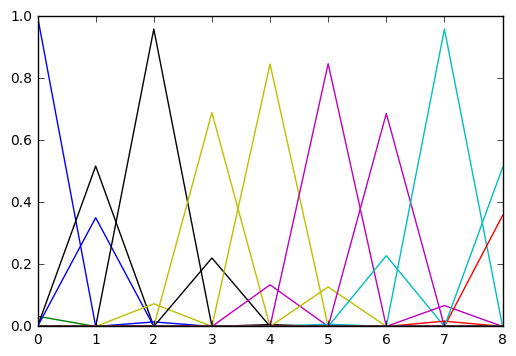

In [68]:
b = npy.zeros((dmp.number_kernels,dmp.time_steps))
for i in range(dmp.number_kernels):
    for t in range(dmp.time_steps):
        b[i,t]=dmp.basis(i,t)        
    plt.plot(range(dmp.time_steps),b[i])    

plt.show()
# dmp.tau =100 

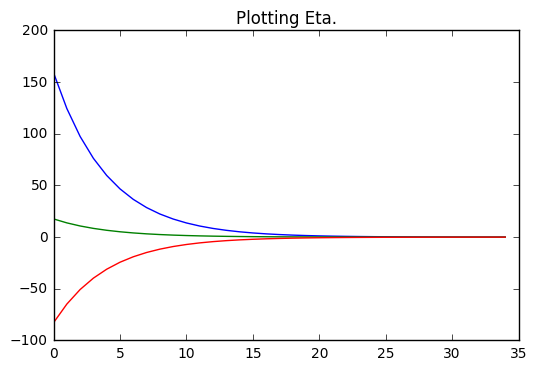

In [49]:
plt.plot(range(dmp.time_steps),dmp.eta)
plt.title("Plotting Eta.")
plt.show()

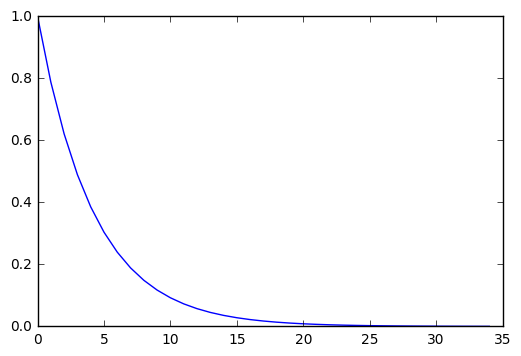

In [50]:
pv = npy.zeros(dmp.time_steps)
for i in range(dmp.time_steps):
    pv[i] = dmp.calc_phase(i)
plt.plot(range(dmp.time_steps),pv)
plt.show()

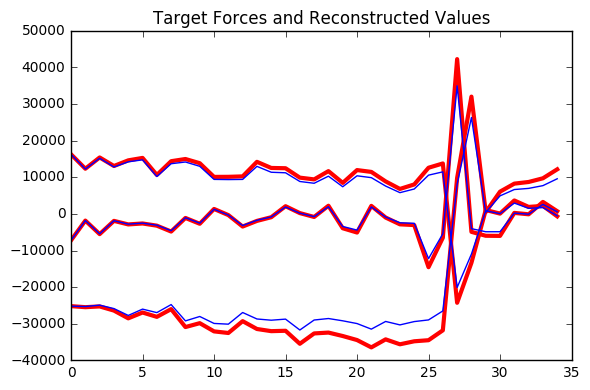

In [51]:
force = npy.zeros((dmp.time_steps,dmp.dimensions))
dmp.goal = copy.deepcopy(dmp.demo_pos[-1])

for t in range(dmp.time_steps):
    den = 0
    for i in range(dmp.number_kernels):
        force[t] += dmp.weights[i]*dmp.basis(i,t)
        den += dmp.basis(i,t)   
    for k in range(dmp.dimensions):
        force[t,k]*=(dmp.goal[k]-dmp.demo_pos[0,k])*dmp.calc_phase(t)/den

tr = range(0,dmp.time_steps)
fig,ax= plt.subplots()
ax.plot(tr,force,'r',label='Reconstructed Forces',linewidth=3)
ax.plot(tr,dmp.target_forces,'b',label='Target Forces')
ax.set_title("Target Forces and Reconstructed Values")
plt.tight_layout()
plt.show()

In [52]:
normalized_demo = copy.deepcopy(dmp.demo_pos)
normalization_vector = dmp.demo_pos[-1]-dmp.demo_pos[0]
normalized_demo -= normalized_demo[0]
normalized_demo /= normalized_demo[-1]

normalized_initial_velocity = npy.diff(normalized_demo,axis=0)[0]
normalized_initial_velocity

array([-0.00503145,  0.02840909, -0.00362319])

In [53]:
start = npy.zeros(dmp.dimensions)
goal = npy.ones(dmp.dimensions)
dmp.rollout(start, goal,normalized_initial_velocity)
# dmp.rollout(start,goal,npy.zeros(3))

1


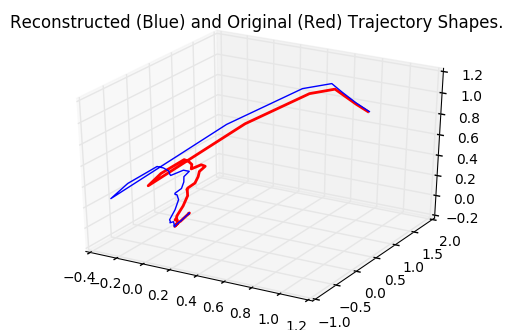

In [54]:
fig = plt.figure()
ax = fig.gca(projection='3d')

np = copy.deepcopy(dmp.demo_pos)
np -= np[0]
np /= np[-1]
ax.plot(np[:,0],np[:,1],np[:,2],'r',linewidth=2)
ax.plot(dmp.pos_roll[:,0],dmp.pos_roll[:,1],dmp.pos_roll[:,2],'b')
# ax.scatter(dmp.pos_roll[ind,0],dmp.pos_roll[ind,1],dmp.pos_roll[ind,2],'r',s=100)
ax.set_title("Reconstructed (Blue) and Original (Red) Trajectory Shapes.")
plt.show()